In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
!ls '../Dados/Fleury/'

 fleury.zip
'Grupo_Fleury_Dataset_Covid19_Dicionário de Dados.xlsx'
 Grupo_Fleury_Dataset_Covid19_Pacientes.csv
 Grupo_Fleury_Dataset_Covid19_Resultados_Exames.csv


## Lendo datasets

In [3]:
fleury = pd.read_csv('../Dados/Fleury/Grupo_Fleury_Dataset_Covid19_Resultados_Exames.csv', sep='|', encoding = "ISO-8859-1")
fleury_pacientes = pd.read_csv('../Dados/Fleury/Grupo_Fleury_Dataset_Covid19_Pacientes.csv', sep='|', encoding = "ISO-8859-1")
fleury = fleury[['ID_PACIENTE', 'DT_COLETA', 'DE_ORIGEM', 'DE_EXAME', 
                       'DE_ANALITO', 'DE_RESULTADO', 'CD_UNIDADE', 'DE_VALOR_REFERENCIA']].copy()

# EDA

In [4]:
fleury_pacientes['IC_SEXO'].value_counts() / fleury_pacientes['IC_SEXO'].value_counts().sum() * 100

F    56.650668
M    43.349332
Name: IC_SEXO, dtype: float64

In [5]:
fleury_pacientes['AA_NASCIMENTO'].drop()

ValueError: Need to specify at least one of 'labels', 'index' or 'columns'

## Casos estranhos

### Três valores de referência para o mesmo exame com mesmo analito

In [6]:
fleury[(fleury['DE_ANALITO'] == 'Covid 19, Anticorpos IgG, Quimiolumin.-Índice') &
       (fleury['DE_EXAME'] == 'COVID19, ANTICORPOS IgG, soro')]['DE_VALOR_REFERENCIA'].unique()

array(['inferior a 1,0', 'inferior a 0,8', 'inferior a 0,9', nan],
      dtype=object)

## Processando

In [7]:
fleury['DE_VALOR_REFERENCIA'] = fleury['DE_VALOR_REFERENCIA'].replace(np.nan, 'NaN')
fleury['CD_UNIDADE'] = fleury['CD_UNIDADE'].replace(np.nan, 'NaN') 

In [8]:
fleury.loc[fleury['DE_VALOR_REFERENCIA'].str.contains('\d+', regex=True), 'DE_RESULTADO'] = 'Number'

In [9]:
fleury.head()

,ID_PACIENTE,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA
0,1AD07C7A1E4D80B608DD7A650766CCF0,19/03/2020,LAB,"NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO P...","Covid 19, Detecção por PCR",NÃO DETECTADO,NaN,Não detectado
1,1AD07C7A1E4D80B608DD7A650766CCF0,19/03/2020,LAB,"NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO P...","Covid 19, Material",raspado de nasofaringe,NaN,NaN
2,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Hemoglobina,Number,g/dL,"13,5 a 17,5"
3,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",VCM,Number,fL,"81,0 a 95,0"
4,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Leucócitos,Number,/mm3,3.500 a 10.500


In [10]:
def check_float(string):
    try:
        number = float(string)
        return 'Number'
    except:
        return string

In [11]:
fleury['DE_RESULTADO'] = fleury['DE_RESULTADO'].str.replace(',', '.')
fleury['DE_RESULTADO'] = fleury['DE_RESULTADO'].apply(lambda x: check_float(x))

## Vários exames de COVID-19

In [12]:
different_covid_exams = fleury[(fleury['DE_EXAME'].str.contains('COV')) | (fleury['DE_EXAME'].str.contains(
    'Corona')) | (fleury['DE_EXAME'].str.contains('CORONAV'))]['DE_EXAME'].unique()

In [13]:
for exam in different_covid_exams:
    print(exam)

NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO POR PCR
COVID19, ANTICORPOS IgG, soro
COVID19, ANTICORPOS IgM, soro
COVID19, ANTICORPOS IgA, soro
SARS-COV-2, ANTICORPOS IgG, soro


In [14]:
different_covid_exams.size

5

In [15]:
fleury['count'] = 1

fleury_cov = fleury[fleury['DE_EXAME'].isin(different_covid_exams)].copy()
fleury_cov = fleury_cov.groupby(
    ['DE_EXAME', 'DE_ANALITO', 'DE_RESULTADO', 'CD_UNIDADE', 'DE_VALOR_REFERENCIA']).agg({'count': 'sum'})

In [16]:
fleury

,ID_PACIENTE,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,count
0,1AD07C7A1E4D80B608DD7A650766CCF0,19/03/2020,LAB,"NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO P...","Covid 19, Detecção por PCR",NÃO DETECTADO,NaN,Não detectado,1
1,1AD07C7A1E4D80B608DD7A650766CCF0,19/03/2020,LAB,"NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO P...","Covid 19, Material",raspado de nasofaringe,NaN,NaN,1
2,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Hemoglobina,Number,g/dL,"13,5 a 17,5",1
3,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",VCM,Number,fL,"81,0 a 95,0",1
4,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Leucócitos,Number,/mm3,3.500 a 10.500,1
...,...,...,...,...,...,...,...,...,...
2496586,D843FFC0D6067B15F25FDBA6AA07D235,15/06/2020,LAB,"ANTIGENOS INTRACELULARES, AUTO-ANTICORPOS (FAN)",FAN - Placa Cromossômica Metafásica,Não reagente,NaN,Não reagente,1
2496587,D843FFC0D6067B15F25FDBA6AA07D235,15/06/2020,LAB,"ANTIGENOS INTRACELULARES, AUTO-ANTICORPOS (FAN)",FAN - Citoplasmático,Não reagente,NaN,Não reagente,1
2496588,D843FFC0D6067B15F25FDBA6AA07D235,15/06/2020,LAB,"ANTIGENOS INTRACELULARES, AUTO-ANTICORPOS (FAN)",FAN - Aparelho Mitótico,Não reagente,NaN,Não reagente,1
2496589,D843FFC0D6067B15F25FDBA6AA07D235,15/06/2020,LAB,"FERRITINA, soro",Ferritina,Number,microg/L,15 a 149,1


## Pivot Table 

In [17]:
pivot = fleury.pivot_table(index=['ID_PACIENTE', 'DT_COLETA'], columns='DE_EXAME', values='DE_RESULTADO', aggfunc=np.max)
pivot

DE_ANALITO                                  11-Desoxicorticosterona  \
ID_PACIENTE                      DT_COLETA                            
00007BB4274722A63A38D415ACCD7705 13/05/2020                     NaN   
                                 15/05/2020                     NaN   
                                 21/01/2020                     NaN   
                                 28/11/2019                     NaN   
000085C48A31F50AE4F147392F6F35CF 01/06/2020                     NaN   
...                                                             ...   
FFFEE8D64EC3D42D4544F5DF21F3BAA5 20/05/2020                     NaN   
FFFEF2D4D69B8D55ED11FFB5E0DD661D 13/06/2020                     NaN   
FFFFD7BD5939EF03FA62545752DF57D9 04/06/2020                     NaN   
                                 09/04/2020                     NaN   
FFFFF4B47815FF61F542AF7D3351A200 06/06/2020                     NaN   

DE_ANALITO                                  11-Desoxicortisol  \
ID_PACIENTE                      DT_COLETA                      
00007BB4274722A63A38D415ACCD7705 13/05/2020               NaN   
                                 15/05/2020               NaN   
                                 21/01/2020               NaN   
                                 28/11/2019               NaN   
000085C48A31F50AE4F147392F6F35CF 01/06/2020               NaN   
...                                                       ...   
FFFEE8D64EC3D42D4544F5DF21F3BAA5 20/05/2020               NaN   
FFFEF2D4D69B8D55ED11FFB5E0DD661D 13/06/2020               NaN   
FFFFD7BD5939EF03FA62545752DF57D9 04/06/2020               NaN   
                                 09/04/2020               NaN   
FFFFF4B47815FF61F542AF7D3351A200 06/06/2020               NaN   

DE_ANALITO                                  17-Alfa-Hidroxiprogesterona  \
ID_PACIENTE                      DT_COLETA                                
00007BB4274722A63A38D415ACCD7705 13/05/2020                         NaN   
                                 15/05/2020                         NaN   
                                 21/01/2020                         NaN   
                                 28/11/2019                         NaN   
000085C48A31F50AE4F147392F6F35CF 01/06/2020                         NaN   
...                                                                 ...   
FFFEE8D64EC3D42D4544F5DF21F3BAA5 20/05/2020                         NaN   
FFFEF2D4D69B8D55ED11FFB5E0DD661D 13/06/2020                         NaN   
FFFFD7BD5939EF03FA62545752DF57D9 04/06/2020                         NaN   
                                 09/04/2020                         NaN   
FFFFF4B47815FF61F542AF7D3351A200 06/06/2020                         NaN   

DE_ANALITO                                  17-Hidroxi Pregnenolona  \
ID_PACIENTE                      DT_COLETA                            
00007BB4274722A63A38D415ACCD7705 13/05/2020                     NaN   
                                 15/05/2020                     NaN   
                                 21/01/2020                     NaN   
                                 28/11/2019                     NaN   
000085C48A31F50AE4F147392F6F35CF 01/06/2020                     NaN   
...                                                             ...   
FFFEE8D64EC3D42D4544F5DF21F3BAA5 20/05/2020                     NaN   
FFFEF2D4D69B8D55ED11FFB5E0DD661D 13/06/2020                     NaN   
FFFFD7BD5939EF03FA62545752DF57D9 04/06/2020                     NaN   
                                 09/04/2020                     NaN   
FFFFF4B47815FF61F542AF7D3351A200 06/06/2020                     NaN   

DE_ANALITO                                  17-alfa-hidroxiprogesterona  \
ID_PACIENTE                      DT_COLETA                                
00007BB4274722A63A38D415ACCD7705 13/05/2020                         NaN   
                                 15/05/2020                         NaN   
                              

In [18]:
pivot.to_csv('pivot_caching.csv', index=False)

## Grouping by instances

When we group by intances, we're getting a distribuition of how many instances did a given exam.

In [17]:
values = fleury['DE_EXAME'].value_counts()
values

HEMOGRAMA, sangue total                                 785838
URINA TIPO I - JATO MEDIO                               206216
COVID19, ANTICORPOS IgG, soro                           175728
COVID19, ANTICORPOS IgM, soro                           168763
NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO POR PCR    100518
                                                         ...  
PESQUISA DE TOXOPLASMA GONDII POR MÉTODO MOLECULAR           1
RUBEOLA, AVIDEZ DE ANTICORPOS IgG, soro                      1
ZINCO, urina                                                 1
ACIDO LACTICO, plasma (amostra arterial)                     1
IgE ESPECÍFICO, rHev B8 LÁTEX, soro                          1
Name: DE_EXAME, Length: 722, dtype: int64

Each patient appears with the same exams many times...

In [18]:
fleury['ID_PACIENTE'].value_counts()

FD10C24CA5986B00FFDDED743447EC81    908
CE1F4D06FE83023E08DF680EC7324BF5    756
D1FF1DC925E1126296C7A210AD234E14    745
C871E03A1744DBBB71A116A1DF657373    707
A9DEF7F65875D4B92E59D50F9B21DCF2    697
                                   ... 
3E2BEBB4C1320DB9BDE20BCD9F332A3F      2
9FF3F587DDF05C3C5F20CDF581211772      2
7F09162B735D691BCAEC1755B34A5D62      2
273CD446E6C929501C12F95842B4398F      1
C0C91D37570E97ACD7A59A3E9ECA1DAD      1
Name: ID_PACIENTE, Length: 129595, dtype: int64

## Grouping by patient and exam type

We'll normalize our dataset in such a way that the tuple (ID_PACIENTE, DE_EXAME) becomes a single instance, in order to find out the most representative exams in terms of the distribuition of patients.

In [37]:
id_paciente_de_exame = fleury.groupby(['ID_PACIENTE', 'DE_EXAME'], as_index=False).agg({'count':'sum'})

<span style='color:red'>**Strange:**</span> Did someone _really_ do 660 hemograms?

In [38]:
id_paciente_de_exame.sort_values(['count'], ascending=False)

,ID_PACIENTE,DE_EXAME,count
986929,FD10C24CA5986B00FFDDED743447EC81,"HEMOGRAMA, sangue total",660
984506,FC5675885071BBF89EE97CFFBB80B5D8,"HEMOGRAMA, sangue total",440
978242,FAA5901EFED27DA59E52593A315F28C3,"HEMOGRAMA, sangue total",430
163485,2A48A97C9B3F9890B9161E398033E52B,"HEMOGRAMA, sangue total",428
331778,5534A67A9A354C52E29D5F36F7A9FFF5,"HEMOGRAMA, sangue total",416
...,...,...,...
575718,9359C5C99CE7AC72F287E5B84FBB2D6F,"FOSFATASE ALCALINA (ALP), soro",1
575719,9359C5C99CE7AC72F287E5B84FBB2D6F,"GAMA GLUTAMIL TRANSFERASE (GAMA-GT), soro",1
575720,9359C5C99CE7AC72F287E5B84FBB2D6F,"GLICOSE, plasma",1
575721,9359C5C99CE7AC72F287E5B84FBB2D6F,"GLOBULINA LIGADORA DE HORMONIOS SEXUAIS(SHBG),...",1


In [39]:
exam_per_patient_distribuition = id_paciente_de_exame['DE_EXAME'].value_counts() / id_paciente_de_exame['ID_PACIENTE'].nunique()

In [40]:
exam_per_patient_distribuition[exam_per_patient_distribuition > 0.1]

COVID19, ANTICORPOS IgG, soro                           0.665944
COVID19, ANTICORPOS IgM, soro                           0.642070
NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO POR PCR    0.371272
HEMOGRAMA, sangue total                                 0.193102
CREATININA, soro                                        0.158293
TRIGLICERIDES, soro                                     0.153432
HORMONIO TIROESTIMULANTE (TSH), soro                    0.153293
COLESTEROL TOTAL, soro                                  0.153100
HDL-COLESTEROL, soro                                    0.152305
TRANSAMINASE GLUTAMICO-PIRUVICA (TGP)                   0.149959
LDL-COLESTEROL, soro                                    0.149010
TRANSAMINASE GLUTAMICO-OXALACETICA (TGO)                0.148864
NÃO-HDL-COLESTEROL, soro                                0.148787
VLDL-COLESTEROL, soro                                   0.144273
UREIA, soro                                             0.140777
TIROXINA (T4) LIVRE, soro

## Distribuition of the most important exams...

In [77]:
%%time
grouped = id_paciente_de_exame.groupby('ID_PACIENTE')
representative_exams_list = exam_per_patient_distribuition.index[:9].to_list()
df = pd.DataFrame(columns=["ID_PACIENTE", *representative_exams_list])

instances = []

for id_paciente, group in grouped:
    aux = {'ID_PACIENTE':id_paciente}
    
    set1 = set(representative_exams_list)
    set2 = set(group['DE_EXAME'])
    
    intersection = set1.intersection(set2)
    
    aux.update({i : True for i in intersection})
    
    instances.append(aux)
        
df = df.append(instances)
df.fillna(False, inplace=True)

CPU times: user 38 s, sys: 197 ms, total: 38.2 s
Wall time: 39.4 s


In [84]:
df

ID_PACIENTE                                             00007BB4274722A63A38D415ACCD7705000085C48A31F5...
COVID19, ANTICORPOS IgG, soro                                                                       86303
COVID19, ANTICORPOS IgM, soro                                                                       83209
NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO POR PCR                                                48115
HEMOGRAMA, sangue total                                                                             25025
CREATININA, soro                                                                                    20514
TRIGLICERIDES, soro                                                                                 19884
HORMONIO TIROESTIMULANTE (TSH), soro                                                                19866
COLESTEROL TOTAL, soro                                                                              19841
HDL-COLESTEROL, soro                          

In [86]:
df['COUNT_EXAMS'] = df[representative_exams_list].sum(axis=1)

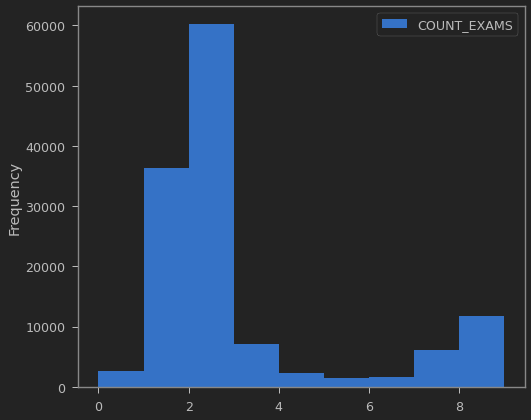

In [99]:
df['COUNT_EXAMS'].value_counts()

df.plot(kind='hist', by=['COUNT_EXAMS'], bins=len(representative_exams_list));